wroking from accuracy 39 base, checking if adding more transformers will increase our accuracy or not

increased accuracy by about 6%

In [1]:


import os
import glob
import random
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader 
     


In [2]:
class CNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[32, 64, 128], img_w=100, img_h=100, num_classes=102):
        super(CNN, self).__init__()
        # our first conv layer will have 32 output channels, a kernel size of 3, a stride of 1, and a padding of 1
        self.conv1 = nn.Conv2d(num_channels, num_out_ch[0], kernel_size=(3,3), stride=(1,1), padding=(1,1))
        # batch normalization layer with 32 channels (same as output of conv layer)
        self.bn1 = nn.BatchNorm2d(num_out_ch[0])
        # our second conv layer will have 64 output channels, a kernel size of 3, a stride of 1, and a padding of 1
        self.conv2 = nn.Conv2d(num_out_ch[0], num_out_ch[1], kernel_size=(3,3), stride=(1,1), padding=(1,1))
        # batch normalization layer with 64 channels (same as output of conv layer)
        self.bn2 = nn.BatchNorm2d(num_out_ch[1])
        # our third conv layer will have 128 output channels, a kernel size of 3, a stride of 1, and a padding of 1
        self.conv3 = nn.Conv2d(num_out_ch[1], num_out_ch[2], kernel_size=(3,3), stride=(1,1), padding=(1,1))
        # batch normalization layer with 128 channels (same as output of conv layer)
        self.bn3 = nn.BatchNorm2d(num_out_ch[2])
        # max pooling layer with kernel size 2 and stride 2
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        # fully connected layer that transforms the output of the conv layers into num_classes
        self.fc = nn.Linear(int(img_w/8)*int(img_h/8)*num_out_ch[2], num_classes)
    
    def forward(self, x):
        # apply first conv layer, then relu, then batch norm, then max pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # apply second conv layer, then relu, then batch norm, then max pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # apply third conv layer, then relu, then batch norm, then max pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # flatten the output of the conv layers
        x = self.fc(x.reshape(x.shape[0], -1))
        
        return x
model = CNN()
x = torch.randn(1, 3, 100, 100)
print(model(x).shape)
y = model(x)
print(y.shape)

torch.Size([1, 102])
torch.Size([1, 102])


In [3]:
# PARAMS
NUM_CHANNELS = [8, 16, 32] # number of output channels for each conv layer
IMG_W = 200 # image width
IMG_H = 200 # image height
NUM_CLASSES = 102 # number of classes (flowers)
BATCH_SIZE = 32 # batch size (number of images to process at once)
NUM_EPOCHS = 6 # number of epochs (times to run the training loop)
LEARNING_RATE = 0.001 # learning rate

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available
print("RUNNING ON: ", device)

# model
# move model to device
model = CNN(num_channels=3, num_out_ch=NUM_CHANNELS, img_w=IMG_W, img_h=IMG_H, num_classes=NUM_CLASSES).to(device)


# loss and optimizer
criterion = nn.CrossEntropyLoss()

optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)

RUNNING ON:  cuda


,image_path,image_label
0,./data/flowers-102/jpg\image_00001.jpg,76
1,./data/flowers-102/jpg\image_00002.jpg,76
2,./data/flowers-102/jpg\image_00003.jpg,76
3,./data/flowers-102/jpg\image_00004.jpg,76
4,./data/flowers-102/jpg\image_00005.jpg,76
...,...,...
8184,./data/flowers-102/jpg\image_08185.jpg,61
8185,./data/flowers-102/jpg\image_08186.jpg,61
8186,./data/flowers-102/jpg\image_08187.jpg,61
8187,./data/flowers-102/jpg\image_08188.jpg,61


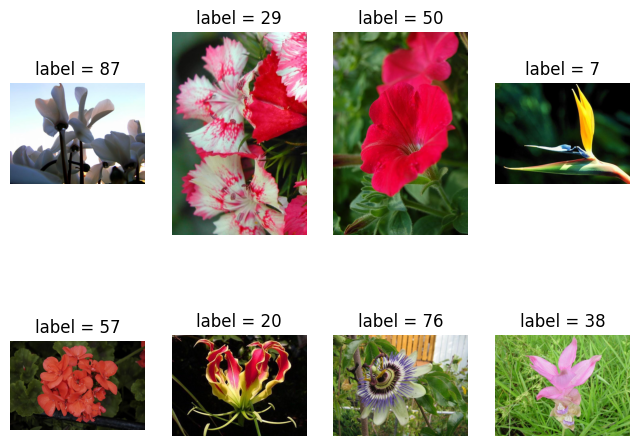

In [4]:
data_path = "./data/flowers-102/jpg" # path to data
labels_path = "./data/flowers-102/imagelabels.mat" # path to labels
label_arr = scp.loadmat(labels_path)['labels'] # load labels
label_arr -= 1 # subtract 1 from each label (labels are 1-indexed)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 6)) # create figure
image_num = random.sample(range(1, 8189), 8) # get 8 random image numbers
for i in range(2): # loop through rows
    for j in range(4): # loop through columns
        image = skio.imread(os.path.join(data_path, f"image_{image_num[i * 4 + j]:05}.jpg")) # read image
        ax[i, j].imshow(image)  # plot image
        ax[i, j].set_title(f"label = {label_arr[0, image_num[i * 4 + j] - 1]}") # set title
        ax[i, j].axis('off') # turn off axis
labels_list = list(set(label_arr[:, 0])) # get list of unique labels
image_paths = sorted(glob.glob(os.path.join(data_path, "*.jpg"))) # get list of image paths
metadata = pd.DataFrame({
    "image_path": image_paths, 
    "image_label": label_arr[0, :].tolist() 
}) # create dataframe with image paths and labels
metadata

In [5]:
class FlowerDataset(Dataset):
    def __init__(self, metadata, transform=None) -> None:
        self.metadata = metadata
        self.transform = transform
    
    def __len__(self):
        return len(self.metadata) # return the number of images in the dataset
    
    def __getitem__(self, idx):
        image_path = self.metadata.iloc[idx, 0] # get image path
        image = skio.imread(image_path) # read image
        label = self.metadata.iloc[idx, 1] # get label
        label = torch.tensor(label)  # Convert label to a PyTorch tensor
        if self.transform:
            image = self.transform(image) # apply transforms
        return (image, label)


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(), # convert numpy array to PIL image
    transforms.RandomHorizontalFlip(), # randomly flip image horizontally
    transforms.RandomRotation(15), # randomly rotate image
    transforms.Resize((IMG_W, IMG_H)), # resize image
    transforms.ToTensor(), # convert PIL image to PyTorch tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # normalize image
])

dataset = FlowerDataset(metadata, transform=transform) # create dataset
train_set, test_set = torch.utils.data.random_split(dataset, [6500, 1689]) # split dataset into train and test sets

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # create train dataloader
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True) # create test dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


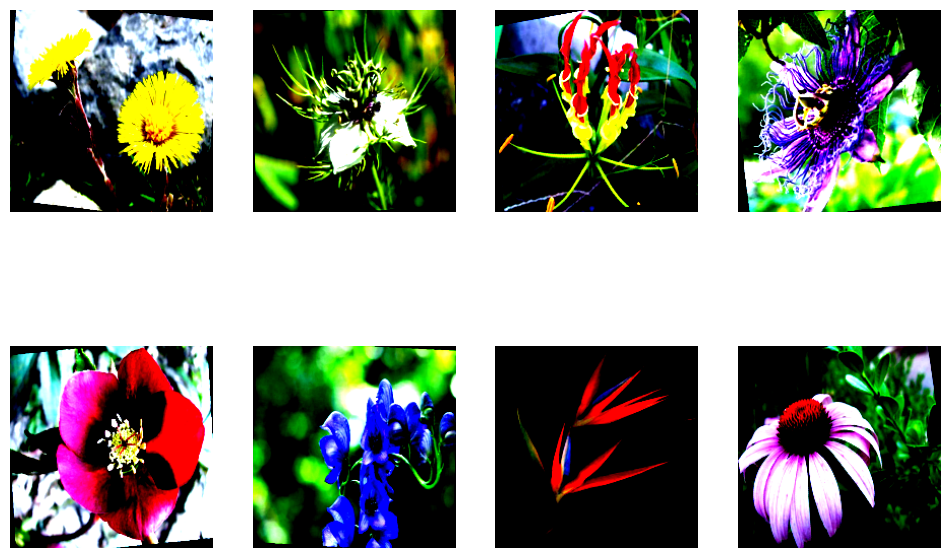

In [7]:
for x,y in train_loader:
    x = x.to(device) # move images to device
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,8)) # create figure
    for i in range(2): # loop through rows
        for j in range(4): # loop through columns
            ax[i,j].imshow(x[i*4+j].cpu().permute(1,2,0)) # plot image
            ax[i,j].axis('off') # turn off axis
    break

In [8]:
def check_accuracy(loader, model):
    correct = 0 
    samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device) # move images to device
            y = y.to(device) # move labels to device
            y_hat = model(x) # get predictions
            _, predictions = y_hat.max(1) # get predictions
            correct += (predictions == y).sum() # add number of correct predictions
            samples += predictions.size(0) # add number of samples
    print(f"Accuracy: {correct}/{samples}: %{correct/samples*100:.2f}") # print accuracy
    model.train() # set model back to train mode

for epoch in range(NUM_EPOCHS):
    running_loss = 0 # running loss
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device) # move images to device
        y = y.to(device) # move labels to device

        y_hat = model(x) # get predictions
        loss = criterion(y_hat, y) # calculate loss
        running_loss += loss # add loss to running loss

        optimiser.zero_grad() # zero gradients
        loss.backward() # calculate gradients
        optimiser.step() # update weights
    print(f"Epoch {epoch+1} of {NUM_EPOCHS}, Loss: {running_loss}") # print loss
    check_accuracy(test_loader, model) # check accuracy
  

Epoch 1 of 6, Loss: 1401.4541015625
Accuracy: 360/1689: %21.31
Epoch 2 of 6, Loss: 623.8563842773438
Accuracy: 566/1689: %33.51
Epoch 3 of 6, Loss: 448.49090576171875
Accuracy: 691/1689: %40.91
Epoch 4 of 6, Loss: 378.7919616699219
Accuracy: 724/1689: %42.87
Epoch 5 of 6, Loss: 327.62542724609375
Accuracy: 741/1689: %43.87
Epoch 6 of 6, Loss: 297.5532531738281
Accuracy: 772/1689: %45.71
